In [ ]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/q99wq7Mmzr33opre1qfGjGpPYYaM7RFC0SsS5yDaRQc
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c lingua-franca-translation -o data

sample_submission.csv:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/437k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

In [ ]:
import os
import pandas as pd
import gensim
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
train_df = pd.read_csv("data/train.csv")

In [ ]:
train_df.head()

id  ...                                            english
0  31989  ...               upon this ladder one of them mounted
1  29884  ...  and solicited at the court of Augustus to be p...
2  26126  ...                                 but how am I sunk!
3  44183  ...      the Yahoos draw home the sheaves in carriages
4  19108  ...          and placed his hated hands before my eyes

[5 rows x 3 columns]

In [ ]:
english = train_df.english.values
crowdtalk = train_df.crowdtalk.values

In [ ]:
test_df=pd.read_csv('data/test.csv')

In [ ]:
test_df.head()

id                                          crowdtalk
0  27226  treuns schleangly throuys praests qeipp cyclui...
1  31034  feosch treuns schleangly gliath spluiey gheuck...
2  35270  scraocs knaedly squiend sriohl clield whaioght...
3  23380  sqaups schlioncy yoik gnoirk cziourk schnaunk ...
4  92117  schlioncy yoik psycheiancy mcountz pously mcna...

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
from fastai.text import *

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [ ]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

In [ ]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [ ]:
from fastai.text import *

In [ ]:
src = Seq2SeqTextList.from_df(train_df,cols='crowdtalk').split_by_rand_pct(seed=42).label_from_df(cols='english')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data = src.databunch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def create_emb(itos,arr,em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    #vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(arr[w])
        except: miss.append(w)
    print(miss)
    return emb

In [ ]:
miss=[]
for i,w in enumerate(data.x.vocab.itos):
  try:
    print(input_token_index[w])
  except:
    miss.append(w)

In [ ]:
miss

In [ ]:
emb_enc = create_emb( data.x.vocab.itos,input_token_index)
emb_dec = create_emb( data.y.vocab.itos,target_token_index)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.', '“', '-', ':', '’s', '?', '(', ')', '!', '‘', 'm.', 'market', 'endian', 'wedding', 'i.', '[', ']', '16th', 'weed', 'xxfake', 'xxfake', 'xxfake', 'xxfake']


In [ ]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([3344, 300]), torch.Size([3296, 300]))

In [ ]:
xb,yb = next(iter(data.valid_dl))

In [ ]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
          h, outp = self.decoder(dec_inp, h)
          dec_inp = outp.max(1)[1]
          res.append(outp)
          if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
xb.shape

torch.Size([64, 30])

In [ ]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [ ]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(3344, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(3296, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=3296, bias=True)
)

In [ ]:
len(xb[0])

30

In [ ]:
h = rnn.encoder(64, xb.cpu())

In [ ]:
h.size()

torch.Size([2, 64, 300])

In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


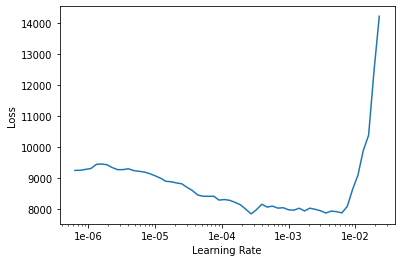

In [ ]:
learn = Learner(test, rnn, loss_func=seq2seq_loss)
learn.lr_find()
learn.recorder.plot()

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


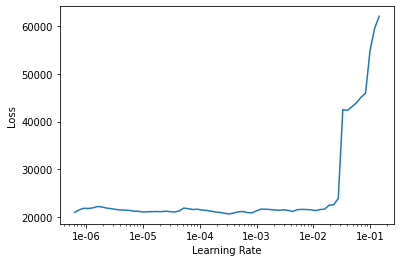

In [ ]:
learn = Learner(test, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(test.y.vocab.itos))])
learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(4, 1e-2)

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700], targets[700], outputs[700]

In [ ]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


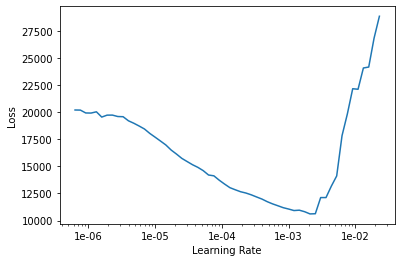

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, 3e-3)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-131-cb72a39fd943>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/train.py:23 in fit_one_cycle                │
│                                                                                           │
│    20 │   callbacks = listify(callbacks)                                                  │
│    21 │   callbacks.append(OneCycleScheduler(learn, max_lr, moms=moms, div_factor=div_fac │
│    22 │   │   │   │   │   │   │   │   │      final_div=final_div, tot_epochs=tot_epochs,  │
│ ❱  23 │   learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)                          │
│    24                                                                                     │
│    25 def fit_fc(learn:Learner, tot_epochs:int=1, lr:float=defaults.lr,  moms:Tuple[float │
│    26 │   │   │   │     wd:float=None, callbacks:Optional[CallbackList]=None)->None:      │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:200 in fit                   │
│                                                                                           │
│   197 │   │   if not getattr(self, 'opt', False): self.create_opt(lr, wd)                 │
│   198 │   │   else: self.opt.lr,self.opt.wd = lr,wd                                       │
│   199 │   │   callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_ │
│ ❱ 200 │   │   fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks) │
│   201 │                                                                                   │
│   202 │   def create_opt(self, lr:Floats, wd:Floats=0.)->None:                            │
│   203 │   │   "Create optimizer with `lr` learning rate and `wd` weight decay."           │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:101 in fit                   │
│                                                                                           │
│    98 │   │   │   cb_handler.on_epoch_begin()                                             │
│    99 │   │   │   for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):            │
│   100 │   │   │   │   xb, yb = cb_handler.on_batch_begin(xb, yb)                          │
│ ❱ 101 │   │   │   │   loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt,  │
│   102 │   │   │   │   if cb_handler.on_batch_end(loss): break                             │
│   103 │   │   │                                                                           │
│   104 │   │   │   if not cb_handler.skip_validate and not learn.data.empty_val:           │
│                                                   

##Model-1

In [ ]:
# Lowercase all characters
english=train_df['english'].apply(lambda x: x.lower())
crowdtalk=train_df['crowdtalk'].apply(lambda x: x.lower())
#crowdtalk_test=test_df['crowdtalk'].apply(lambda x: x.lower())

In [ ]:
len(crowdtalk),len(english)

(11955, 11955)

In [ ]:
# Remove quotes
import re
english=english.apply(lambda x: re.sub("'", '', x))
crowdtalk=crowdtalk.apply(lambda x: re.sub("'", '', x))
#crowdtalk_test=crowdtalk_test.apply(lambda x: re.sub("'", '', x))

In [ ]:
import string
from string import digits
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
english=english.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
crowdtalk=crowdtalk.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
#crowdtalk_test=crowdtalk_test.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
english=english.apply(lambda x: x.translate(remove_digits))
crowdtalk = crowdtalk.apply(lambda x: x.translate(remove_digits))
#crowdtalk_test = crowdtalk_test.apply(lambda x: x.translate(remove_digits))

In [ ]:
# Remove extra spaces
english=english.apply(lambda x: x.strip())
crowdtalk=crowdtalk.apply(lambda x: x.strip())
#crowdtalk_test=crowdtalk_test.apply(lambda x: x.strip())
english=english.apply(lambda x: re.sub(" +", " ", x))
crowdtalk=crowdtalk.apply(lambda x: re.sub(" +", " ", x))
#crowdtalk_test=crowdtalk_test.apply(lambda x: re.sub(" +", " ", x))

In [ ]:
len(english),len(crowdtalk)

(11955, 11955)

In [ ]:
df={
    'text':np.array(crowdtalk[:1000]),
    'target':np.array(english[:1000])
}

In [ ]:
pd.DataFrame(df).to_csv('Train.csv')

In [ ]:
# Add start and end tokens to target sequences
english = english.apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
english[0],crowdtalk[0],crowdtalk_test[0]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-117-9f81ffe4d8cc>:1 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'crowdtalk_test' is not defined

In [ ]:
# Vocabulary of English
all_eng_words=set()
for eng in english:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Crowdtalk
all_crowdtalk_words=set()
for mar in crowdtalk:
    for word in mar.split():
        if word not in all_crowdtalk_words:
            all_crowdtalk_words.add(word)
# for mar in crowdtalk_test:
#     for word in mar.split():
#         if word not in all_crowdtalk_words:
#             all_crowdtalk_words.add(word)

In [ ]:
# Max Length of source sequence
import numpy as np
lenght_list=[]
for l in crowdtalk:
    lenght_list.append(len(l.split(' ')))
# for l in crowdtalk_test:
#     lenght_list.append(len(l.split(' ')))  
max_length_src = np.max(lenght_list)
max_length_src

39

In [ ]:
# Max Length of target sequence
lenght_list=[]
for l in english:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

25

In [ ]:
input_words = sorted(list(all_crowdtalk_words))
target_words = sorted(list(all_eng_words))
num_encoder_tokens = len(all_crowdtalk_words)
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens, num_decoder_tokens

(9245, 9621)

In [ ]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens
num_encoder_tokens+=1

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = crowdtalk,english
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((10759,), (1196,))

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [ ]:
latent_dim = 50
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/100
84/84 [==============================] - 99s 1s/step - loss: 2.7269 - acc: 0.0949 - val_loss: 2.4317 - val_acc: 0.0959
Epoch 2/100
84/84 [==============================] - 84s 998ms/step - loss: 2.3639 - acc: 0.0961 - val_loss: 2.3967 - val_acc: 0.0959
Epoch 3/100
84/84 [==============================] - 80s 947ms/step - loss: 2.2910 - acc: 0.0995 - val_loss: 2.3419 - val_acc: 0.1183
Epoch 4/100
84/84 [==============================] - 82s 980ms/step - loss: 2.2349 - acc: 0.1289 - val_loss: 2.3007 - val_acc: 0.1451
Epoch 5/100
84/84 [==============================] - 78s 932ms/step - loss: 2.1894 - acc: 0.1499 - val_loss: 2.2644 - val_acc: 0.1691
Epoch 6/100
84/84 [==============================] - 79s 946ms/step - loss: 2.1464 - acc: 0.1696 - val_loss: 2.2305 - val_acc: 0.1780
Epoch 7/100
84/84 [==============================] - 78s 926ms/step - loss: 2.1073 - acc: 0.1813 - val_loss: 2.2096 - val_acc: 0.1843
Epoch 8/100
84/84 [==============================] - 78s 924ms/st

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-246-7e280a5af22a>:9 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2030 in fit_generator     │
│                                                                                           │
│   2027 │   │   workers=workers,                                                           │
│   2028 │   │   use_multiprocessing=use_multiprocessing,                                   │
│   2029 │   │   shuffle=shuffle,                                                           │
│ ❱ 2030 │   │   initial_epoch=initial_epoch)                                               │
│   2031                                                                                    │
│   2032   @doc_controls.do_not_generate_docs                                               │
│   2033   def evaluate_generator(self,                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py:64 in error_handler │
│                                                                                           │
│    61 │                                                                                   │
│    62 │   filtered_tb = None                                                              │
│    63 │   try:                                                                            │
│ ❱  64 │     return fn(*args, **kwargs)                                                    │
│    65 │   except Exception as e:  # pylint: disable=broad-except                          │
│    66 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│    67 │     raise e.with_traceback(filtered_tb) from None                                 │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1216 in fit               │
│                                                                                           │
│   1213 │   │   │   │   batch_size=batch_size,                                             │
│   1214 │   │   │   │   _r=1):                                                             │
│   1215 │   │   │     callbacks.on_train_batch_begin(step)                                 │
│ ❱ 1216 │   │   │     tmp_logs = self.train_function(iterator)                             │
│   1217 │   │   │     if data_handler.should_sync:                                         │
│   1218 │   │   │   │   context.async_wait()                                               │
│   1219 │   │   │     logs = tmp_logs  # No error, now safe to assign to logs.             │
│                                                   

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
print(input_seq)
decoded_sentence = decode_sequence(input_seq)
print('Input Crowdtalk sentence:', X_train[k:k+1].values[0])
print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted English Translation:', decoded_sentence[:-4])

[[8243. 5625. 6039.  855. 8255. 8301.  799. 5664. 9126.  853. 1480. 8197.
  5843.  407. 1823. 4251. 3849. 5664. 9126. 4377.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.]]
Input Crowdtalk sentence: treuns schleangly schwaok cycluierg triild truibly cycleed schlioncy yoik cycluiedly flueh traerly schneiald chix gleums mcnatz mcgeaurg schlioncy yoik miiwn
Actual English Translation:  and pass my life here in the conversation of those superior beings the struldbrugs 
Predicted English Translation:  and my were on which i heard in the ground to a


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: praudy treuns schleangly mcdeury stuops prauex schlioncy yoik puiets schneiald chix juies
Actual Marathi Translation:  examining and analysing all the minutiae of causation 
Predicted Marathi Translation:  and thence to examine by the sea 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: treuns schleangly zaiontly schnaump cycluierg triild swoap treuns schleangly hroly
Actual Marathi Translation:  and lifted up my hands and eyes 
Predicted Marathi Translation:  and went at my hand to attend 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: gnuarr jiary shriedy hyoirds ghiuntly chegh
Actual Marathi Translation:  principal secretary for private affairs 
Predicted Marathi Translation:  of you or 


##END MODEL-1

In [ ]:
english_tokens=[]
for i in english:
  english_tokens.append(i.split(' '))

In [ ]:
len(english_tokens),len(english),len(english_token)

(11955, 11955, 11955)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel=MultiLabelBinarizer()
y=multilabel.fit_transform(english_token)

In [ ]:
y.shape

(11955, 9156)

In [ ]:
multilabel.classes_

array(['a', 'abandon', 'abandoned', ..., 'zeal', 'zealots', 'zwin'],
      dtype=object)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', max_features=10000)
X = tfidf.fit_transform(crowdtalk)

In [ ]:
tfidf_y = TfidfVectorizer(analyzer='word', max_features=50)
Y_tf=tfidf_y.fit_transform(english)

In [ ]:
X.shape,y.shape

((11955, 9245), (11955, 9156))

In [ ]:
len(tfidf.get_feature_names()),len(tfidf_y.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(9245, 50)

In [ ]:
tfidf_y.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['all',
 'an',
 'and',
 'are',
 'as',
 'at',
 'be',
 'been',
 'but',
 'by',
 'could',
 'for',
 'from',
 'great',
 'had',
 'have',
 'he',
 'her',
 'him',
 'his',
 'in',
 'into',
 'is',
 'it',
 'me',
 'my',
 'not',
 'of',
 'on',
 'one',
 'or',
 'so',
 'some',
 'that',
 'the',
 'their',
 'them',
 'they',
 'this',
 'to',
 'upon',
 'was',
 'we',
 'were',
 'when',
 'which',
 'who',
 'with',
 'would',
 'you']

In [ ]:
x=X.toarray()

In [ ]:
y_tf=Y_tf.toarray()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import numpy as np

In [ ]:
x.shape,y.shape

((11955, 9245), (11955, 9156))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['upon','this','ladder','one','of','them','mounted']]
candidate = ['a', 'and', 'in', 'my', 'of', 'the', 'to', 'was', 'with']
score = sentence_bleu(reference, candidate)
print(score)

0.5773502691896257


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization

In [ ]:
def score_blue(y_test,y_pred):
  tt=[]
  for i in y_test[0]:
    tt.append(i)
  ttt=[]
  ttt.append(tt)
  list_test=[]
  for i in multilabel.inverse_transform(np.array(ttt))[0]:
    list_test.append(i)
  tt=[]
  for i in y_pred[0]:
    tt.append(i)
  ttt=[]
  ttt.append(tt)
  list_pred=[]
  for i in multilabel.inverse_transform(np.array(ttt))[0]:
    list_pred.append(i)
  reference = [list_test]
  candidate = list_pred
  score = sentence_bleu(reference, candidate)
  print(score)
  return score


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
# Create the model
model = Sequential()
model.add(Dense(32,activation='relu', input_dim=x.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy',score_blue])

# Fit data to model
history=model.fit(x,y, epochs=10,batch_size=16,validation_split=0.2,shuffle=True)

Epoch 1/10


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-156-4c588f5bc3d1>:21 in <module>                                           │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py:67 in error_handler │
│                                                                                           │
│    64 │     return fn(*args, **kwargs)                                                    │
│    65 │   except Exception as e:  # pylint: disable=broad-except                          │
│    66 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│ ❱  67 │     raise e.with_traceback(filtered_tb) from None                                 │
│    68 │   finally:                                                                        │
│    69 │     del filtered_tb                                                               │
│    70                                                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/func_graph.py:1129 in  │
│ autograph_handler                                                                         │
│                                                                                           │
│   1126 │   │   │   │   ))                                                                 │
│   1127 │   │     except Exception as e:  # pylint:disable=broad-except                    │
│   1128 │   │   │   if hasattr(e, "ag_error_metadata"):                                    │
│ ❱ 1129 │   │   │     raise e.ag_error_metadata.to_exception(e)                            │
│   1130 │   │   │   else:                                                                  │
│   1131 │   │   │     raise                                                                │
│   1132                                                                                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 878, in 
train_function  *
        return step_function(self, iterator)
    File "<ipython-input-155-a294c285f9f9>", line 8, in score_blue  *
        for i in multilabel.inverse_transform(np.array(ttt))[0]:
    File "/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py", line 901, 
in inverse_transform  *
        raise ValueError(

    ValueError: Expected indicator for 9156 classes, but got 1

In [ ]:
pp=model.predict(tfidf.transform(['wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts']).toarray())

9156

In [ ]:
tt=[]
for i in pp[0]:
  if i>0.01:
    tt.append(1)
  else:
    tt.append(0)
ttt=[]
ttt.append(tt)

In [ ]:
for i in multilabel.inverse_transform(np.array(ttt))[0]:
  print(i)

a
and
in
my
of
the
to
was
with


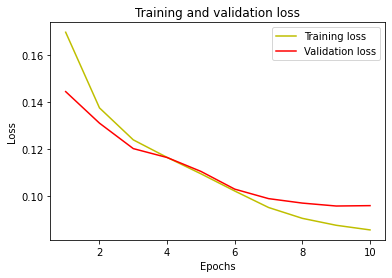

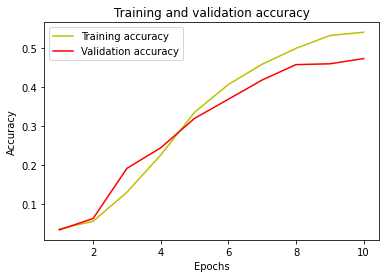

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
learning_rate = 0.003
#input_shape, output_sequence_length, english_vocab_size, french_vocab_size
# Build the layers    
model = Sequential()
# Embedding
model.add(Embedding(x.shape[1],128, input_length=x.shape[1],
                         input_shape=x.shape[1:]))
# Encoder
model.add(Bidirectional(GRU(128)))
model.add(RepeatVector(y_tf.shape[1]))
# Decoder
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(y_tf.shape[1], activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
# model = model_final(x.shape,y.shape[1],
#                         len(x_tk.word_index)+1,
#                         len(y_tk.word_index)+1)
model.summary()
model.fit(x, y_tf, batch_size=1024, epochs=25, validation_split=0.2,shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9245, 128)         1183360   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 100, 256)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         296448    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 100, 512)         131584    
 ibuted)                                                

In [ ]:
len(english),len(crowdtalk)

(11955, 11955)

In [ ]:
count=0
mapping_words={}
for i in range(len(english)):
  crowd_tokens=crowdtalk[i].split(' ')
  english_tokens=english[i].split(' ')
  if(len(crowd_tokens)==len(english_tokens)):
    count+=1
    for i in range(len(crowd_tokens)):
      if crowd_tokens[i] in mapping_words.keys():
        mapping_words[crowd_tokens[i]].append(english_tokens[i])
      else:
        mapping_words[crowd_tokens[i]]=[]
        mapping_words[crowd_tokens[i]].append(english_tokens[i])

In [ ]:
len(mapping_words),count

(284, 65)

In [ ]:
import re
import string
def clean_text(text):
#will replace the html characters with " "
    text=re.sub('<.*?>', ' ', text)  
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    #will consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will split and join the words
    text=' '.join(text.split())
    return text
#Running the Funtion


In [ ]:
for i in mapping_words.keys():
  l=[]
  for j in mapping_words[i]:
    input_text=j
    new_text=clean_text(input_text)
    if new_text not in l:
      l.append(new_text)
  mapping_words[i]=l

In [ ]:
english_token=[clean_text(c).split(' ') for c in english]

In [ ]:
for i in mapping_words.keys():
  l=[]
  for j in mapping_words[i]:
    if j!='' and j!=' ':
      l.append(j)
  mapping_words[i]=l

In [ ]:
for i in mapping_words.keys():
  if len(mapping_words[i])>1:
    print(i,mapping_words[i])

phost ['kirwin', 'krempe']
tuisp ['partly', 'out']
schneiald ['out', 'care']
schlioncy ['continued', 'replied', 'after']


In [ ]:
crowdtalk[0],english[0]

('wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts',
 'upon this ladder one of them mounted')

In [ ]:
i=crowdtalk[0].split(' ')
for s in i:
  if s in mapping_words.keys():
    print(s,mapping_words[s])

In [ ]:
count=0
for i in range(len(english)):
  ct=clean_text(crowdtalk[i])
  crowd_tokens=ct.split(' ')
  eng=clean_text(english[i])
  english_tokens=eng.split(' ')
  if(len(crowd_tokens)<len(english_tokens)):
    count+=1
    print(ct+" *** "+eng)

In [ ]:
i='schlioncy yoik czerty sooc kniousts hyuefy liourd pros'.split(' ')
for s in i:
  if s in mapping_words.keys():
    print(s,mapping_words[s])

schlioncy ['continued', 'replied', 'after']
yoik ['the']


In [ ]:
mapping_words['rhiaorly']=['you']
mapping_words['speush']=['then']
mapping_words['pfeaught']=['safe']
mapping_words['schliull']=['and']
mapping_words['hrauerty']=['elizabeth and']
mapping_words['naay']=['ernest']

In [ ]:
count=0
for i in range(len(english)):
  ct=clean_text(crowdtalk[i])
  crowd_tokens=ct.split(' ')
  eng=clean_text(english[i])
  english_tokens=eng.split(' ')
  if(len(crowd_tokens)>len(english_tokens)):
    count+=1
    for j in range(len(english_tokens)):
      if crowd_tokens[j] in mapping_words:
        mapping_words[crowd_tokens[j]].append(english_tokens[j])
      else:
        mapping_words[crowd_tokens[j]]=[]
        mapping_words[crowd_tokens[j]].append(english_tokens[j])

In [ ]:
count

11886

In [ ]:
mapping_words

{'mccleub': ['said',
  'the',
  'were',
  'it',
  'd',
  'to',
  'me',
  'that',
  'flestrin',
  'so',
  'he',
  'this',
  'waldman',
  'into',
  'words',
  'countrymen',
  'back',
  'had',
  'could',
  'altogether',
  'in',
  'manmountain',
  'which',
  'is',
  'understand',
  'thing',
  'smothered',
  'shall'],
 'sqieusch': ['said', 'mr', 'shown', 'kirwin', 'edmund'],
 'mcduaft': ['mr', 'kirwin', 'me', 'said', 'hastened'],
 'phost': ['kirwin',
  'krempe',
  'motions',
  'feverish',
  'proceedings',
  'with',
  'horror',
  'moral',
  'pedro',
  'and',
  'to',
  'decide',
  'mortal',
  'of',
  'a',
  'same',
  'greatest',
  'own',
  'teeth',
  'strange',
  'heart',
  'his',
  'the',
  'very',
  'animal',
  'show',
  'live',
  'ingenuity',
  'mole',
  'more',
  'passions',
  'weddingnight',
  'despair',
  'infantile',
  'in',
  'what',
  'one',
  'electricity',
  'hand',
  'my',
  'arms',
  'i',
  'three',
  'some',
  'many',
  'english',
  'single',
  'kindness',
  'anguish',
  'wood',

In [ ]:
for i in mapping_words.keys():
  l=[]
  for j in mapping_words[i]:
    if j not in l:
      l.append(j)
  mapping_words[i]=l

In [ ]:
for i in mapping_words.keys():
  if len(mapping_words[i])>1:
    print(i,mapping_words[i])

mccleub ['said', 'the', 'were', 'it', 'd', 'to', 'me', 'that', 'flestrin', 'so', 'he', 'this', 'waldman', 'into', 'words', 'countrymen', 'back', 'had', 'could', 'altogether', 'in', 'manmountain', 'which', 'is', 'understand', 'thing', 'smothered', 'shall']
sqieusch ['said', 'mr', 'shown', 'kirwin', 'edmund']
mcduaft ['mr', 'kirwin', 'me', 'said', 'hastened']
phost ['kirwin', 'krempe', 'motions', 'feverish', 'proceedings', 'with', 'horror', 'moral', 'pedro', 'and', 'to', 'decide', 'mortal', 'of', 'a', 'same', 'greatest', 'own', 'teeth', 'strange', 'heart', 'his', 'the', 'very', 'animal', 'show', 'live', 'ingenuity', 'mole', 'more', 'passions', 'weddingnight', 'despair', 'infantile', 'in', 'what', 'one', 'electricity', 'hand', 'my', 'arms', 'i', 'three', 'some', 'many', 'english', 'single', 'kindness', 'anguish', 'wood', 'plans', 'difficulty', 'feelings', 'recommendation', 'chaff', 'rapidity', 'vigour', 'rushmats', 'earnestness', 'who', 'it', 'at', 'penetrate', 'point', 'rage', 'utmost', 

In [ ]:
processedLines = [gensim.utils.simple_preprocess(sentence) for sentence in english]
eng_word_list = [word for words in processedLines for word in words]

In [ ]:
processedLines = [gensim.utils.simple_preprocess(sentence) for sentence in crowdtalk]
crowdtalk_word_list = [word for words in processedLines for word in words]

In [ ]:
len(eng_word_list),len(crowdtalk_word_list)

(106625, 163380)

In [ ]:
len(np.unique(crowdtalk_word_list)),len(np.unique(eng_word_list))

(9245, 9000)

In [ ]:
eng_word_list_unique=np.unique(eng_word_list)
crowdtalk_word_list_unique=np.unique(crowdtalk_word_list)

In [ ]:
dict1 = dict(zip(crowdtalk_word_list, eng_word_list))

In [ ]:
dict1

In [ ]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english[sample_i]))
    print('crowdtalk sample {}:  {}\n'.format(sample_i + 1, crowdtalk[sample_i]))

English sample 1:  upon this ladder one of them mounted
crowdtalk sample 1:  wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts

English sample 2:  and solicited at the court of Augustus to be preferred to a greater ship
crowdtalk sample 2:  treuns schleangly kriaors draotz pfiews schlioncy yoik gaiacts schneiald chix augustus luag rhairk gnoirk cziourk mcmaaght gnoirk cziourk wrauebs rhiorf ghiicy jist

English sample 3:  but how am I sunk!
crowdtalk sample 3:  toirts choolt chiugy knusm squiend sriohl gheold

English sample 4:  the Yahoos draw home the sheaves in carriages
crowdtalk sample 4:  schlioncy yoik yahoos dynuewn maery schlioncy yoik xiep cycluiedly flueh smieunts

English sample 5:  and placed his hated hands before my eyes
crowdtalk sample 5:  treuns schleangly tsiens mcgaantz schmeecks truosp swoap smoub cycluierg triild hroly



In [ ]:
import collections
english_words_counter = collections.Counter([word for sentence in english for word in sentence.split()])
crowdtalk_words_counter = collections.Counter([word for sentence in crowdtalk for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} crowdtalk words.'.format(len([word for sentence in crowdtalk for word in sentence.split()])))
print('{} unique crowdtalk words.'.format(len(crowdtalk_words_counter)))
print('10 Most common words in the crowdtalk dataset:')
print('"' + '" "'.join(list(zip(*crowdtalk_words_counter.most_common(10)))[0]) + '"')

112421 English words.
11787 unique English words.
10 Most common words in the English dataset:
"the" "of" "and" "to" "I" "a" "my" "in" "was" "that"

163380 crowdtalk words.
9245 unique crowdtalk words.
10 Most common words in the crowdtalk dataset:
"schlioncy" "yoik" "schneiald" "chix" "treuns" "schleangly" "gnoirk" "cziourk" "squiend" "sriohl"


In [ ]:
#import project_tests as tests
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

#tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [ ]:
#import project_tests as tests
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_crowdtalk_sentences,preproc_english_sentences,crowdtalk_tokenizer,english_tokenizer =\
    preprocess(crowdtalk,english)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_crowdtalk_sequence_length = preproc_crowdtalk_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
crowdtalk_vocab_size = len(crowdtalk_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max crowdtalk sentence length:", max_crowdtalk_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("crowdtalk vocabulary size:", crowdtalk_vocab_size)

Data Preprocessed
Max English sentence length: 26
Max crowdtalk sentence length: 39
English vocabulary size: 9298
crowdtalk vocabulary size: 9245


In [ ]:
def  model_final (input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.003

    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

print('Final Model Loaded')

Final Model Loaded


In [ ]:
preproc_crowdtalk_sentences.shape,preproc_english_sentences.shape

((11955, 39), (11955, 26, 1))

In [ ]:
preproc_crowdtalk_sentences[1:].shape

(11954, 39)

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed crowdtalk data
    :param x_tk: English tokenizer
    :param y_tk: Crowdtalk tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
    model.summary()
    model.fit(x, y, batch_size=1024, epochs=10, validation_split=0.1,shuffle=True)
    return model


model=final_predictions(preproc_crowdtalk_sentences,preproc_english_sentences,crowdtalk_tokenizer,english_tokenizer)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 39, 128)           1183488   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              197376    
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 26, 256)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 26, 256)          295680    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 26, 512)          131584    
 tributed)                                            

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-101-f9b3fcece98b>:18 in <module>                                           │
│ <ipython-input-101-f9b3fcece98b>:14 in final_predictions                                  │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py:64 in error_handler │
│                                                                                           │
│    61 │                                                                                   │
│    62 │   filtered_tb = None                                                              │
│    63 │   try:                                                                            │
│ ❱  64 │     return fn(*args, **kwargs)                                                    │
│    65 │   except Exception as e:  # pylint: disable=broad-except                          │
│    66 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│    67 │     raise e.with_traceback(filtered_tb) from None                                 │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1216 in fit               │
│                                                                                           │
│   1213 │   │   │   │   batch_size=batch_size,                                             │
│   1214 │   │   │   │   _r=1):                                                             │
│   1215 │   │   │     callbacks.on_train_batch_begin(step)                                 │
│ ❱ 1216 │   │   │     tmp_logs = self.train_function(iterator)                             │
│   1217 │   │   │     if data_handler.should_sync:                                         │
│   1218 │   │   │   │   context.async_wait()                                               │
│   1219 │   │   │     logs = tmp_logs  # No error, now safe to assign to logs.             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py:150 in   │
│ error_handler                                                                             │
│                                                                                           │
│   147 │                                                                                   │
│   148 │   filtered_tb = None                                                              │
│   149 │   try:                                                                            │
│ ❱ 150 │     return fn(*args, **kwargs)                                                    │
│   151 │   except Exception as e:                                                          │
│   152 │     filtered_tb = _process_traceback_frame

In [ ]:
y_tk=english_tokenizer
x_tk=crowdtalk_tokenizer
y=preproc_english_sentences
x=preproc_crowdtalk_sentences

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
y[0].shape

(26, 1)

In [ ]:
%%time
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(x_tk.word_index)+1,
                     300,
                     input_length=x.shape[1]))
model.add(SimpleRNN(100))
model.add(Dense(y.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(0.003),
                  metrics=['accuracy'])
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 39, 300)           2773800   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dense_11 (Dense)            (None, 26)                2626      
                                                                 
Total params: 2,816,526
Trainable params: 2,816,526
Non-trainable params: 0
_________________________________________________________________
CPU times: user 220 ms, sys: 2.98 ms, total: 223 ms
Wall time: 277 ms


In [ ]:
history=model.fit(x, y, epochs=10, batch_size=64,validation_split=0.2,shuffle=True) #Multiplying by Strategy to run on TPU's

Epoch 1/10


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-115-f51585cd62c2>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py:67 in error_handler │
│                                                                                           │
│    64 │     return fn(*args, **kwargs)                                                    │
│    65 │   except Exception as e:  # pylint: disable=broad-except                          │
│    66 │     filtered_tb = _process_traceback_frames(e.__traceback__)                      │
│ ❱  67 │     raise e.with_traceback(filtered_tb) from None                                 │
│    68 │   finally:                                                                        │
│    69 │     del filtered_tb                                                               │
│    70                                                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/func_graph.py:1129 in  │
│ autograph_handler                                                                         │
│                                                                                           │
│   1126 │   │   │   │   ))                                                                 │
│   1127 │   │     except Exception as e:  # pylint:disable=broad-except                    │
│   1128 │   │   │   if hasattr(e, "ag_error_metadata"):                                    │
│ ❱ 1129 │   │   │     raise e.ag_error_metadata.to_exception(e)                            │
│   1130 │   │   │   else:                                                                  │
│   1131 │   │   │     raise                                                                │
│   1132                                                                                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 878, in 
train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 867, in 
step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 860, in 
run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 817, in 
train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/compile_utils.py", line 460, in
update_state
        metric_obj.upda

In [ ]:
x.shape,y.shape

In [ ]:
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

In [ ]:
sentence = 'wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])
predictions = model.predict(sentences, len(sentences))

In [ ]:
import re
rres=' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]])
re.sub(' +', ' ', rres.replace('<PAD>',''))

'the the the the the of '

In [ ]:
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))

” ” ” ” ” ” ” ” ” because if if if if if if if if if if if if if if because because
the the the the the of <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
upon this ladder one of them mounted <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
y_id_to_word

In [ ]:
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'he saw a old yellow truck'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])
predictions = model.predict(sentences, len(sentences))

print('Sample 1:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
print('Il a vu un vieux camion jaune')
print('Sample 2:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))

##SUBMISSION

In [ ]:
test_df = pd.read_csv("data/test.csv")

In [ ]:
def generate_batch_test(X,batch_size=1):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            #decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            #decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text) in enumerate(X[j:j+batch_size]):
                for t, word in enumerate(input_text.split()):
                  try:
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                  except:
                    print(word)
            yield([decode_sequence(encoder_input_data)])

In [ ]:
X_test=test_df['crowdtalk'].values

In [ ]:
X_test[5:6]

array(['mcik schlioncy yoik gnoirk cziourk hydriour sploct schneiald chix gleums throds'],
      dtype=object)

In [ ]:
for j in range(5,6, 1):
  print(j)
  encoder_input_data = np.zeros((1, max_length_src),dtype='float32')
  for i,input_text in enumerate(X_test[j:j+1]):
    print(i,input_text)
    for t, word in enumerate(input_text.split()):
      try:
        encoder_input_data[i, t] = input_token_index[word] # encoder input seq
        print(input_token_index[word])
      except:
        print(i,t,word)
  #print(decode_sequence(encoder_input_data))

5
0 mcik schlioncy yoik gnoirk cziourk hydriour sploct schneiald chix gleums throds
3918
5664
9126
1954
913
2336
0 6 sploct
5843
407
1823
8092


In [ ]:
test_gen=generate_batch_test(X_test)
k=-1

In [ ]:
k

-1

In [ ]:
predictions=[]
while(k<len(X_test)-1):
  k+=1
  print(k)
  (input_seq) = next(test_gen)
  decoded_sentence = input_seq[0]
  print(decoded_sentence)
  #decoded_sentence = decode_sequence(input_seq)
  predictions.append(decoded_sentence[:-4])
  #print('Predicted English Translation:', decoded_sentence[:-4])

Streaming output truncated to the last 5000 lines.
1817
 for it a more than me for _END
1818
 there was a shift to their wife or _END
1819
 and the th of mind of our people had _END
1820
 the king of mind or me _END
1821
 i was now to be in a ship _END
1822
 which i had not down _END
1823
 or one of one of the inhabitants _END
1824
 and my master from his master as which i had _END
1825
spiirm
 and the same than that had taken by me and with a ship
1826
knaolt
 we are in the th day of the cottage _END
1827
 but i could not not discover the same of her friends
1828
kluily
 i saw him with a few voice _END
1829
 that i would have with that country and have a loss
1830
 i saw me of my own majesty to the same _END
1831
 and to the king of mind to my head and about the ground
1832
 and if he would do with your eyes _END
1833
chroect
 and my majesty were out of his friends _END
1834
 i would take them on the same quantity of wood _END
1835
 you to me _END
1836
 they the bigness to about about

In [ ]:
predictions[0]

' and of it of them '

In [ ]:
len(predictions),predictions[0]

(3985, ' and of it of them ')

In [ ]:
k+=1
print(k)
(input_seq) = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Crowdtalk sentence:', X_test[k:k+1][0])
print('Predicted English Translation:', decoded_sentence[:-4])

2
Input Crowdtalk sentence: scraocs knaedly squiend sriohl clield whaioght spleorry mcmiaors cycluierg triild twoiasts
Predicted English Translation:  when i i sat on the court 


In [ ]:
crowdtalk_test = test_df.crowdtalk.values
processedLines = [gensim.utils.simple_preprocess(sentence) for sentence in crowdtalk_test]

In [ ]:
X_test=tfidf.transform([crowdtalk_test[0]])
pred=model.predict(X_test.toarray())

In [ ]:
predd=tfidf_y.inverse_transform(pred)
for i in range(len(pred[0])):
  if pred[0][i]>0.005:
    print(predd[0][i])

and
of
one
them


In [ ]:
for i in crowdtalk_test:
  X_test=tfidf.transform(i)
  pred=model.predict(X_test)

In [ ]:
def output_prediction(sentence):
  # preprocess_x, x_tk = tokenize(x)
  # preprocess_x = pad(preprocess_x)
  sentence = [crowdtalk_tokenizer.word_index[word] for word in sentence.split()]
  sentence = pad_sequences([sentence], maxlen=preproc_crowdtalk_sentences.shape[-1], padding='post')
  sentences = np.array([sentence[0], preproc_crowdtalk_sentences[0]])
  predictions = model.predict(sentences)
  print(predictions)
  y_id_to_word = {value: key for key, value in english_tokenizer.word_index.items()}
  return ' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]])

In [ ]:
sentence ='wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts'
sentence=[crowdtalk_tokenizer.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=preproc_crowdtalk_sentences.shape[-1], padding='post')
sentences = np.array([sentence[0], preproc_crowdtalk_sentences[0]])
predictions = model.predict(sentences)
y_id_to_word = {value: key for key, value in english_tokenizer.word_index.items()}

In [ ]:
y_id_to_word[0]='PAD'
[y_id_to_word[np.argmax(x)] for x in predictions[0]]

In [ ]:
output_prediction('wraov driourth wreury hyuirf schneiald chix loir schloors rhiuny pfaiacts')

In [ ]:
len(processedLines),test_df.shape

In [ ]:
prediction=[]
count=0
for i in crowdtalk_test:
  sentence = i
  try:
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))
    rres=' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]])
    result=re.sub(' +', ' ', rres.replace('<PAD>',''))
  except:
    count+=1
    result=''
  prediction.append(result)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-133-770c883d2f30>:3 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'crowdtalk_test' is not defined

In [ ]:
len(mapping_words)

7034

In [ ]:
sentence = []

for i in test_df.crowdtalk.values:
  sent=i.split(' ')
  sentence_part = []
  word = ''
  for j in sent:
    if j in mapping_words:
      word = ' '.join(mapping_words[j])
    else:
      word = ''.join(' ')
    sentence_part.append(word)
    temp = ' '.join(sentence_part)
  sentence.append(temp)

In [ ]:
len(predictions),test_df.shape

(3985, (3985, 3))

In [ ]:
predictions[0]

Text [ 2 11 11]

In [ ]:
predictions=[]
for i in predicted:
  print(i,i[:-7])
  if i[-7:]==' <end> ':
    predictions.append(i[:-7])
  else:
    predictions.append(i)

and consequently be a few minutes <end>  and consequently be a few minutes
whereupon i had the most beautiful and affection <end>  whereupon i had the most beautiful and affection
when i had no longer <end>  when i had no longer
about the same time i had been the most ingenious people <end>  about the same time i had been the most ingenious people
the first nag and the most beautiful and incoherent <end>  the first nag and the most beautiful and incoherent
by the th of the same time <end>  by the th of the same time
i fell from the same account of the same country <end>  i fell from the same account of the same country
he had a few of the same time <end>  he had a few of the same time
that of a few minutes <end>  that of a few minutes
and of their own fortune <end>  and of their own fortune
but you will be a very scanty time <end>  but you will be a very scanty time
by my master had been the most beautiful and the most beautiful and the most beautiful and the most beautiful and the mos

In [ ]:
test_df['prediction'] = predictions

In [ ]:
test_df.drop(['english'],axis=1,inplace=True)

In [ ]:
test_df.head()

id                                          crowdtalk     prediction
0  27226  treuns schleangly throuys praests qeipp cyclui...  xxbos and and
1  31034  feosch treuns schleangly gliath spluiey gheuck...  xxbos and and
2  35270  scraocs knaedly squiend sriohl clield whaioght...  xxbos and and
3  23380  sqaups schlioncy yoik gnoirk cziourk schnaunk ...  xxbos the the
4  92117  schlioncy yoik psycheiancy mcountz pously mcna...  xxbos was was

In [ ]:
!rm -rf assets
!mkdir assets
test_df.to_csv(os.path.join("assets", "submission.csv"), index=False)

In [ ]:
%aicrowd notebook submit -c lingua-franca-translation -a assets --no-verify

Mounting Google Drive 💾

Your Google Drive will be mounted to access the colab notebook

##MODEL-3

In [ ]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    print(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [ ]:
test.show_batch

<bound method DataBunch.show_batch of Seq2SeqDataBunch;

Train: LabelList (9564 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk draotz pfiews schlioncy yoik gaiacts schneiald chix xxunk luag rhairk gnoirk cziourk xxunk gnoirk cziourk wrauebs rhiorf ghiicy jist,xxbos toirts choolt chiugy knusm squiend sriohl gheold,xxbos treuns schleangly tsiens mcgaantz schmeecks truosp swoap smoub cycluierg triild hroly,xxbos mcnaiaks traff sooc kniousts schneiald chix shraungly liosh,xxbos squiend sriohl spluiey gheuck huiec mccruems zally mcdiaongs faioty sprauhl squiend sriohl xxunk thruiety schloors rhiuny
y: TextList
xxbos and xxunk at the court of xxmaj xxunk to be xxunk to a greater ship,xxbos but how am i sunk !,xxbos and placed his hated hands before my eyes,xxbos that was of smooth stone .,xxbos as i gathered from some general words i xxunk among them
Path: .;

Valid: LabelList (2391 items)
x: Seq2SeqTextList
xxbos squiend sriohl tsiens stuops prauex cycluierg triild sprauhl,xxbos sq

In [ ]:
v = test.vocab

In [ ]:
v.stoi['xxpad']

1

In [ ]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [ ]:
test.add_tfm(shift_tfm)

In [ ]:
d = 30
torch.arange(0., d, 2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

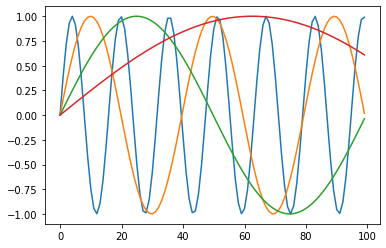

In [ ]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [ ]:
res[:6,:6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

In [ ]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [ ]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

In [ ]:
def get_output_mask(inp, pad_idx=1):
    #print(inp.size())
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

In [ ]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [ ]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [ ]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        #print(out)
        #print(inp)
        #print('****')
        #print(out)
        #inp= inp[0][0]
        print(inp)
        #out=tensor(out)
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

In [ ]:
n_x_vocab,n_y_vocab = len(test.train_ds.x.vocab.itos), len(test.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab,d_model=256)
learn = Learner(test, model,metrics=[accuracy, CorpusBLEU(n_y_vocab)],loss_func = CrossEntropyFlat())

In [ ]:
test.batch_size

32

In [ ]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

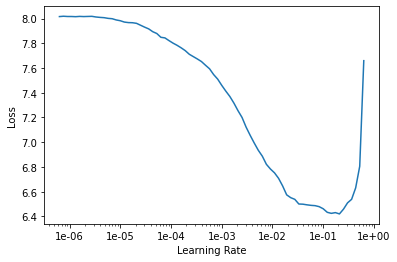

In [ ]:
learn.recorder.plot()

In [ ]:
learn.lr_find()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[array([  2,  13,  14, 300,  21,  22,  23,  24, 513,  55,  56,  19,  20, 592,  15,  16, 661,  83,  84,  49,  50,   9,
        10, 724,  25,  26,  81,  82, 156,  27,  28,  77,  78,  17,  18, 471, 981,   9,  10,   0]), array([  2,  11, 234,  16,  17, 427,  34,  15, 524,  12, 594,  49,  64,  30,   9, 657,  18,  47,  67,  19,  13,  45,
       406, 922,   9,   0,  14])], [array([   2,   49,   50,   17,   18,   69,   70,  757,  423,   41,   42,  304,   49,   50,    9,   10, 1644, 2321,
         11,   12,   19,   20,  465,    0, 1065,  314,   23,   24,  336,   77,   78,   69,   70, 2127,   15,   16,
         29,   30,  703]), array([   2,   30,   13,   40,  690,  356,   27,  237,   30,    9, 1575, 2248,   10,   15,  400,    0, 1000,  246,
         17,  251,   45,   40, 2056,   20,   12,  678,   14])], [array([   2,    0,   13,   14,    0,  223,  790,   33,   34,  133,   39,   40,   67,   68,   15,   16,    0,    9,
         10, 1038,   11,   12,    9,   10,    0, 1206,   15,   16,   41,   42

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:156: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Streaming output truncated to the last 5000 lines.
        [   2, 2512, 1388,    9,   10,  712,    9,   10,   11,   12, 1006],
        [   2,   23,   24,  902,   25,   26,  303,  795,   15,   16, 3160],
        [   2,   41,   42,   25,   26,  920,   63,   64,   37,   38,  220],
        [   2,   57,   58,    0,    9,   10,   15,   16,  345, 2782,    0],
        [   2, 1908,   87,   88,   90,    0,   13,   14,   19,   20,    0],
        [   2,   49,   50,   25,   26,   39,   40, 2835,   47,   48,  623],
        [   2,   93,  140,   83,   84,  253,  590,  290,   23,   24,    0],
        [   2,    9,   10, 2371,   45,   46,  401,   11,   12, 2372, 2873],
        [   2,   81,   82,    0,   11,   12,  102,  444,   11,   12, 1091],
        [   2,   13,   14,    0,   19,   20, 2277,    0,   11,   12, 1778]])
[[array([  2,   9,  10, 197, 210, 469, 106,  55,  56, 223, 287,  15,  16, 703,  94]), array([  2,   9,  86,  79, 404,  55,  34, 160, 211,  12, 678,  51,  14])], [array([   2,    9,   10,  

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[array([   2,   17,   18,  333,   55,   56,    9,   10,  336,   21,   22,   41,   42,    9,   10, 1066,   11,   12,
         39,   40,   25,   26,  818,   13,   14,  229,    9,   10,   45,   46,  473,   79,   80,  161,  274,  108,
       1505,   23,   24,  145]), array([   2,   13,  268,   34,    9,  251,   16,   27,    9, 1001,   10,   25,   18,  757,   11,  148,   28,    9,
        407,   46,   75,  213,  103, 1438,   17,  124])], [array([   2,   79,   80,  143,  131,   19,   20,  405,   31,   32,   92,  106,  125,   21,   22,   39,   40,    0,
        309,   63,   64,   27,   28,  234,    9,   10,   11,   12,  501,  105,    9,   10, 1206,   25,   26,  585,
        114]), array([   2,   46,   70,  118,   15,  295,   21,   87,   55,  104,   16,   25,    0,  241,   37,   19,  167,   10,
          9,  396,  102,    9, 1137,   18,  519,  107,   14])], [array([   2,   17,   18, 1220,   23,   24, 1758,   31,   32,  655,   13,   14,   25,   26,  166,   15,   16, 2614,
         19,   20,   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:156: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Streaming output truncated to the last 5000 lines.
        [   2,   98,    0,   37,   38,  371,   63,   64,   37,   38,  460,   31,
           32,    0,    1],
        [   2,   13,   14,   65,   66,   71,   72,   53,   54, 1522,   51,   52,
           15,   16, 1478],
        [   2,   13,   14,    9,   10, 1495,  438,   99,  102,  125,   51,   52,
           15,   16,    0],
        [   2,   57,   58,   67,   68,   47,   48,  181,  535,  525,  770,   11,
           12,  128, 3209],
        [   2,   31,   32,  704, 2469,  174,   47,   48,   59,   60, 1659,   55,
           56,  246,  446],
        [   2,  133,    9,   10, 1025,   11,   12, 1226,  149, 1759,   94,   15,
           16,   85,   86],
        [   2,   13,   14,   17,   18,  456,   15,   16,  586,    9,   10,   31,
           32,  378,    0],
        [   2,   13,   14,   25,   26,   17,   18,  585,  778,   47,   48,   19,
           20,  867,  371],
        [   2,  476,  232,   29,   30,   55,   56,   19,   20, 2654,    0,   

Streaming output truncated to the last 5000 lines.
           21,   22,  453,    1],
        [   2,   25,   26,   17,   18,   21,   22,  109,    0,    1,    1,    1,
            1,    1,    1,    1],
        [   2,   43,   44, 2639,   15,   16, 1996,   87,   88,    1,    1,    1,
            1,    1,    1,    1],
        [   2,  113,  848,  309,  144,    0,   13,   14,    0,    1,    1,    1,
            1,    1,    1,    1],
        [   2,  218,  215,   23,   24,  263,   63,   64, 2731,    1,    1,    1,
            1,    1,    1,    1]])
[[array([   2,  122, 1079,   75,   76,  483,   15,   16, 2166]), array([   2,   58, 1014,   44,  417,   12, 2095])], [array([  2,  13,  14, 848,  55,  56,  19,  20, 603]), array([  2,  11, 785,  34,  15, 542])], [array([   2,   31,   32, 1528,    0,   55,   56,   83,   84]), array([   2,   21, 1461,    0,   34,   49])], [array([  2, 538, 118,  17,  18,  53,  54, 192,   0]), array([  2,   5, 472, 112,  13,  31,  89,   0, 175])], [array([  2,   9,  10,

In [ ]:
learn.data.test_ds

LabelList (3985 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk praests qeipp cycluierg triild schneiald chix siess,xxbos xxunk treuns schleangly gliath spluiey gheuck sooc kniousts squiend sriohl,xxbos scraocs knaedly squiend sriohl clield whaioght spleorry mcmiaors cycluierg triild twoiasts,xxbos sqaups schlioncy yoik gnoirk cziourk schnaunk tiontly dieung schroegs tweuws schrioun schwauh szaiabs,xxbos schlioncy yoik psycheiancy mcountz pously mcnaiaks traff xxunk
y: TextList
xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none
Path: .

In [ ]:
learn.model.eval

<bound method Module.eval of Transformer(
  (enc_emb): TransformerEmbedding(
    (embed): Embedding(3344, 256)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.1, inplace=False)
  )
  (dec_emb): TransformerEmbedding(
    (embed): Embedding(3296, 256)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.0, inplace=False)
  )
  (encoder): ModuleList(
    (0): EncoderBlock(
      (mha): MultiHeadAttention(
        (q_wgt): Linear(in_features=256, out_features=256, bias=True)
        (k_wgt): Linear(in_features=256, out_features=256, bias=True)
        (v_wgt): Linear(in_features=256, out_features=256, bias=True)
        (out): Linear(in_features=256, out_features=256, bias=True)
        (drop_att): Dropout(p=0.1, inplace=False)
        (drop_res): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (ff): SequentialEx(
        (layers): ModuleList(
          (0): Linear(in_features=256, out_features=1024, bias=Tr

In [ ]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [ ]:
preds = []
for i in range(0,30):
  #print(test.test_ds.x[i])
  p = learn.predict(test.test_ds.x[i])
  print(p)
  preds.append(str(p[0]))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-327-53502f4a325f>:4 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:372 in predict               │
│                                                                                           │
│   369 │                                                                                   │
│   370 │   def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, wi │
│   371 │   │   "Return predicted class, label and probabilities for `item`."               │
│ ❱ 372 │   │   batch = self.data.one_item(item)                                            │
│   373 │   │   res = self.pred_batch(batch=batch, with_dropout=with_dropout)               │
│   374 │   │   raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]               │
│   375 │   │   norm = getattr(self.data,'norm',False)                                      │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:182 in one_item               │
│                                                                                           │
│   179 │   │   "Get `item` into a batch. Optionally `detach` and `denorm`."                │
│   180 │   │   ds = self.single_ds                                                         │
│   181 │   │   with ds.set_item(item):                                                     │
│ ❱ 182 │   │   │   return self.one_batch(ds_type=DatasetType.Single, detach=detach, denorm │
│   183 │                                                                                   │
│   184 │   def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse │
│   185 │   │   "Show a batch of data in `ds_type` on a few `rows`."                        │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:169 in one_batch              │
│                                                                                           │
│   166 │   │   dl = self.dl(ds_type)                                                       │
│   167 │   │   w = dl.num_workers                                                          │
│   168 │   │   dl.num_workers = 0                                                          │
│ ❱ 169 │   │   try:     x,y = next(iter(dl))                                               │
│   170 │   │   finally: dl.num_workers = w                                                 │
│   171 │   │   if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)                  │
│   172 │   │   norm = getattr(self,'norm',False)                                           │
│                                                   

In [ ]:
test_df.head()

id                                          crowdtalk
0  27226  treuns schleangly throuys praests qeipp cyclui...
1  31034  feosch treuns schleangly gliath spluiey gheuck...
2  35270  scraocs knaedly squiend sriohl clield whaioght...
3  23380  sqaups schlioncy yoik gnoirk cziourk schnaunk ...
4  92117  schlioncy yoik psycheiancy mcountz pously mcna...

In [ ]:
! [ -e /content ] && pip install -Uqq fastai 

     |████████████████████████████████| 189 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [ ]:
 learn.save('model-stage-1') # save model
 learn.load('model-stage-1')

Learner(data=Seq2SeqDataBunch;

Train: LabelList (9564 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk draotz pfiews schlioncy yoik gaiacts schneiald chix xxunk luag rhairk gnoirk cziourk xxunk gnoirk cziourk wrauebs rhiorf ghiicy jist,xxbos toirts choolt chiugy knusm squiend sriohl gheold,xxbos treuns schleangly tsiens mcgaantz schmeecks truosp swoap smoub cycluierg triild hroly,xxbos mcnaiaks traff sooc kniousts schneiald chix shraungly liosh,xxbos squiend sriohl spluiey gheuck huiec mccruems zally mcdiaongs faioty sprauhl squiend sriohl xxunk thruiety schloors rhiuny
y: TextList
xxbos and xxunk at the court of xxunk to be xxunk to a greater ship,xxbos but how am i sunk !,xxbos and placed his hated hands before my eyes,xxbos that was of smooth stone .,xxbos as i gathered from some general words i xxunk among them
Path: .;

Valid: LabelList (2391 items)
x: Seq2SeqTextList
[  2  13  14   0 452 483  23  24  11  12 732],[  2  13  14   0 452 483  23  24  11  12 732],[  2  13  14  

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
test_sample=test_df.crowdtalk[0]

In [ ]:
learn.predict([test_sample])

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-90-a465dabd746d>:1 in <module>                                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:372 in predict               │
│                                                                                           │
│   369 │                                                                                   │
│   370 │   def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, wi │
│   371 │   │   "Return predicted class, label and probabilities for `item`."               │
│ ❱ 372 │   │   batch = self.data.one_item(item)                                            │
│   373 │   │   res = self.pred_batch(batch=batch, with_dropout=with_dropout)               │
│   374 │   │   raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]               │
│   375 │   │   norm = getattr(self.data,'norm',False)                                      │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:182 in one_item               │
│                                                                                           │
│   179 │   │   "Get `item` into a batch. Optionally `detach` and `denorm`."                │
│   180 │   │   ds = self.single_ds                                                         │
│   181 │   │   with ds.set_item(item):                                                     │
│ ❱ 182 │   │   │   return self.one_batch(ds_type=DatasetType.Single, detach=detach, denorm │
│   183 │                                                                                   │
│   184 │   def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse │
│   185 │   │   "Show a batch of data in `ds_type` on a few `rows`."                        │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:169 in one_batch              │
│                                                                                           │
│   166 │   │   dl = self.dl(ds_type)                                                       │
│   167 │   │   w = dl.num_workers                                                          │
│   168 │   │   dl.num_workers = 0                                                          │
│ ❱ 169 │   │   try:     x,y = next(iter(dl))                                               │
│   170 │   │   finally: dl.num_workers = w                                                 │
│   171 │   │   if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)                  │
│   172 │   │   norm = getattr(self,'norm',False)                                           │
│                                                   

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            print(f'output tensor : {out}')
            for z in out:
              print(f'output: {learn.data.train_ds.y.reconstruct(z.argmax(1))}')
              outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
            # for x,y,z in zip(xb[0],xb[1],out):
            #     #inputs.append(learn.data.train_ds.x.reconstruct(x))
            #     #targets.append(learn.data.train_ds.y.reconstruct(y))
            #     outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
learn.data.test_ds

LabelList (3985 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk praests qeipp cycluierg triild schneiald chix siess,xxbos xxunk treuns schleangly gliath spluiey gheuck sooc kniousts squiend sriohl,xxbos scraocs knaedly squiend sriohl clield whaioght spleorry mcmiaors cycluierg triild twoiasts,xxbos sqaups schlioncy yoik gnoirk cziourk schnaunk tiontly dieung schroegs tweuws schrioun schwauh szaiabs,xxbos schlioncy yoik psycheiancy mcountz pously mcnaiaks traff xxunk
y: TextList
xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none
Path: .

In [ ]:
_,_,predictions=get_predictions(learn,DatasetType.Test)

[[array([  2,  13,  14,  55,  56, 317,  45,  46, 150,  73,  74, 786, 465,  11,  12,  39,  40, 217,  25,  26,   9,  10,
        55,  56, 276,  11,  12, 149, 430,  37,  38, 259,  57,  58,  19,  20, 464,  11,  12,   0]), array([2, 5, 9])], [array([   2,   13,   14,   35,   36,   17,   18, 1729,    9,   10,  628,   17,   18,  239,  119, 1782,   13,   14,
          0,    0,   43,   44,  188,   59,   60,   15,   16,    0,   29,   30,   13,   14,    0,   29,   30,   15,
         16,   41,   42,  125]), array([2, 5, 9])], [array([  2,  13,  14, 385,  33,  34, 279, 124,  21,  22, 534, 865,  23,  24,   9,  10,   0,  11,  12,  67,  68, 238,
        25,  26,  17,  18,  33,  34, 349, 209,   9,  10,   0,  21,  22,  11,  12, 482, 156]), array([2, 5, 9])], [array([   2,    9,   10, 1626,   11,   12,    0,   19,   20,    0,   13,   14, 1526,   19,   20,   23,   24,  198,
         94,    0,   59,   60,  492,   15,   16,  220,   19,   20, 1223,   23,   24, 1700,   27,   28,    0,   15,
         16,   83,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)


Streaming output truncated to the last 5000 lines.
        [   2,   53,   54,  118,  752,   21,   22, 1050,   55,   56,  109,  517],
        [   2,  110,  951,   53,   54,    0,    9,   10,  440,   17,   18,  239],
        [   2,   43,   44,   17,   18,  577,   19,   20,   23,   24,  189,    0],
        [   2,   21,   22,  353,  150,   29,   30,   23,   24,   83,   84, 1462],
        [   2,   13,   14,   17,   18,    0,   55,   56,  115,   21,   22, 1419]])
output tensor : tensor([[[-7.1586e-01,  5.7063e+00,  1.7899e+01,  ..., -1.9157e+00,
          -1.9879e+00, -2.0176e+00],
         [ 4.9221e+00,  6.0222e+00,  4.1130e+00,  ..., -2.7284e+00,
          -2.7924e+00, -2.8025e+00],
         [ 3.9743e+00,  5.4621e+00,  2.3187e+00,  ..., -1.8933e+00,
          -1.9147e+00, -2.0144e+00]],

        [[-8.8393e-01,  5.5314e+00,  1.7191e+01,  ..., -1.1110e+00,
          -1.2635e+00, -1.2391e+00],
         [ 3.9766e+00,  6.1562e+00,  4.4446e+00,  ..., -2.0889e+00,
          -2.1133e+00, -2.1238e+

In [ ]:
print(inputs[0])
print(predictions[0])
print(targets[0])

xxbos toirts choolt hyuefy liourd tsuiefy geuss muwn schlioncy yoik boft schneiald chix diaotz mcnaiaks traff naan squiend sriohl twurg gnoirk cziourk luag rhairk schlioncy yoik symbiety xxunk cycluierg triild gnoirk cziourk cloigs keaufy groos tsuar splaash klaionk daioc mceab
xxbos but but so blind is the study of man that what i conceived to be the best xxunk to my plan may entirely entirely destroyed . may
xxbos xxmaj but so blind is the experience of man that what i conceived to be the best xxunk to my plan may have entirely destroyed it .


In [ ]:
inputs[0]

Text [   2   49   50   81   82 2121   71   72    9   10 3078   11   12  125   27   28  158   17   18  818   15   16   51
   52    9   10  580    0   23   24   15   16 1819  191   69   70  706  844   39   40]

In [ ]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(preds, dim=1)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-161-3e0eda592691>:2 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: iteration over a 0-d array

In [ ]:
print(predictions[0])

xxbos and and


In [ ]:
len(predictions)

3985

In [ ]:
len(input),len(output),len(target)

(2391, 2391, 2391)

In [ ]:
learn.data.train_ds.x.reconstruct(input[0])

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-104-67607fd086e6>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/text/data.py:339 in reconstruct             │
│                                                                                           │
│   336 │   │   return self.label_const(0, **kwargs)                                        │
│   337 │                                                                                   │
│   338 │   def reconstruct(self, t:Tensor):                                                │
│ ❱ 339 │   │   idx_min = (t != self.pad_idx).nonzero().min()                               │
│   340 │   │   idx_max = (t != self.pad_idx).nonzero().max()                               │
│   341 │   │   return Text(t[idx_min:idx_max+1], self.vocab.textify(t[idx_min:idx_max+1])) │
│   342                                                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/core.py:190 in __eq__                       │
│                                                                                           │
│   187 │   │   "Subclass this method if you want to apply data augmentation with `tfms` to │
│   188 │   │   if tfms: raise Exception(f"Not implemented: you can't apply transforms to t │
│   189 │   │   return self                                                                 │
│ ❱ 190 │   def __eq__(self, other): return recurse_eq(self.data, other.data)               │
│   191                                                                                     │
│   192 def recurse_eq(arr1, arr2):                                                         │
│   193 │   if is_listy(arr1): return is_listy(arr2) and len(arr1) == len(arr2) and np.all( │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'int' object has no attribute 'data'

In [ ]:
input[0],output[0],target[0]

(Text [   2   49   50   81   82 2121   71   72    9   10 3078   11   12  125   27   28  158   17   18  818   15   16   51
    52    9   10  580    0   23   24   15   16 1819  191   69   70  706  844   39   40],
 Text [   2   30   30   47 2050   41    9  591   10  104   19   77   13  757   12   32    9  513    0   12   17 1756  144
   638  638  781   14  144],
 Text [   2    5   30   47 2050   41    9 3015   10  104   19   77   13  757   12   32    9  513    0   12   17 1756  144
    40  638  781   25   14])

In [ ]:
learn.data.valid_ds

LabelList (2391 items)
x: Seq2SeqTextList
xxbos squiend sriohl tsiens stuops prauex cycluierg triild sprauhl,xxbos squiend sriohl gnoarg gloiatz gnoirk cziourk schreerd cycluiedly flueh,xxbos mcmoorth dwiountz stuops prauex kielt mcnaiaks traff squiend sriohl treiahl typeauty schmeips krousp luag rhairk spleann sqaups schlioncy yoik gnoirk cziourk xxunk juirst schneiald chix psychoak,xxbos wheians veurg geuss muwn ghurly qaiatch kwaort tiontly dieung mcuosp xxunk phost floff sweunt xxunk,xxbos spreerts cycluiedly flueh xxunk treuns schleangly schnoont cycluierg triild khoepp xxunk
y: TextList
xxbos i placed all my words,xxbos i bent down to go in,xxbos xxmaj they all agreed that i could not be produced according to the xxunk laws of nature,xxbos which is an unnatural office he always xxunk with great xxunk,xxbos employed in xxunk and arranging my chemical xxunk .
Path: .

In [ ]:
predictions, *_ = learn.get_preds(DatasetType.Valid)
labels = np.argmax(predictions, 1)

[[array([   2,   49,   50,   81,   82, 2121,   71,   72,    9,   10, 3078,   11,   12,  125,   27,   28,  158,   17,
         18,  818,   15,   16,   51,   52,    9,   10,  580,    0,   23,   24,   15,   16, 1819,  191,   69,   70,
        706,  844,   39,   40]), array([   2,    5,   30,   47, 2050,   41,    9, 3015,   10,  104,   19,   77,   13,  757,   12,   32,    9,  513,
          0,   12,   17, 1756,  144,   40,  638,  781,   25,   14])], [array([   2,   49,   50,   65,   66, 1550,   25,   26,   81,   82,  136,   13,   14, 2078,   27,   28,   75,   76,
          9,   10, 1021,   47,   48,   41,   42,   17,   18,  160,   35,   36,    0,  672,   15,   16,   39,   40,
         67,   68,    0]), array([   2,    5,   30,   38, 1484,   18,   47,   67,   11, 2939,   19,   44,    9,  959,   29,   27,   13,   23,
         65,    0,  602,   12,   25,   39,    0])], [array([   2,   45,   46,   39,   40,   25,   26,   47,   48,  535,   11,   12,   65,   66,    0,   92,   27,   28,
         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)


[[array([   2,   61,   62,  167, 1119,   17,   18, 1789, 3008,   13,   14,  864,   27,   28,  602,  101,    0,   23,
         24,  235,   92,   17,   18,   27,   28,  199, 1640,   83,   84, 1091,   13,   14,  376]), array([   2,    5,   36,   75, 1056,   13, 1726, 2944,   11,  803,   19,  541,   52,    0,   17,  168,   87,   19,
         13,   83, 1570,   49,  951,   11,  308,   14])], [array([   2,   33,   34,   39,   40,   71,   72,   21,   22,    9,   10,  373,    9,   10,   11,   12, 1647,   15,
         16,  940,    9,   10,  268,  323,    9,   10,    0,   11,   12, 1243,   13,   14,    0]), array([   2,   22,   25,   41,   16,    9,  306,   10,    9, 1232,   12,  881,    9,  205,  257,    9,    0,   10,
       1052,   11,    0])], [array([   2,   23,   24,  237,  174,  126, 3258,   21,   22,   37,   38,  926,   13,   14,   92,  157,  804,   23,
         24,   11,   12, 1121,   47,   48,    0,  137,   23,   24, 1423,  152, 1744,  162,  196]), array([   2,    5,   17,  145,   80,  

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-95-1cddf3850b99>:1 in <module>                                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:341 in get_preds             │
│                                                                                           │
│   338 │   │   if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)   │
│   339 │   │   callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_ │
│   340 │   │   return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(c │
│ ❱ 341 │   │   │   │   │   │    activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)     │
│   342 │                                                                                   │
│   343 │   def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, r │
│   344 │   │   │   │      with_dropout:bool=False, activ:nn.Module=None) -> List[Tensor]:  │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:44 in get_preds              │
│                                                                                           │
│    41 │   │   │     activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[in │
│    42 │   "Tuple of predictions and targets, and optional losses (if `loss_func`) using ` │
│    43 │   res = [to_float(torch.cat(o).cpu()) for o in                                    │
│ ❱  44 │   │      zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False │
│    45 │   if loss_func is not None:                                                       │
│    46 │   │   with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))       │
│    47 │   if activ is not None: res[0] = activ(res[0])                                    │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:43 in <listcomp>             │
│                                                                                           │
│    40 def get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler: │
│    41 │   │   │     activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[in │
│    42 │   "Tuple of predictions and targets, and optional losses (if `loss_func`) using ` │
│ ❱  43 │   res = [to_float(torch.cat(o).cpu()) for o in                                    │
│    44 │   │      zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False │
│    45 │   if loss_func is not None:                                                       │
│    46 │   │   with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))       │
╰───────────────────────────────────────────────────

In [ ]:
p,t=learn.get_preds(DatasetType.Valid)
print(p)
print(t)

[[array([   2,   49,   50,   81,   82, 2121,   71,   72,    9,   10, 3078,   11,   12,  125,   27,   28,  158,   17,
         18,  818,   15,   16,   51,   52,    9,   10,  580,    0,   23,   24,   15,   16, 1819,  191,   69,   70,
        706,  844,   39,   40]), array([   2,    5,   30,   47, 2050,   41,    9, 3015,   10,  104,   19,   77,   13,  757,   12,   32,    9,  513,
          0,   12,   17, 1756,  144,   40,  638,  781,   25,   14])], [array([   2,   49,   50,   65,   66, 1550,   25,   26,   81,   82,  136,   13,   14, 2078,   27,   28,   75,   76,
          9,   10, 1021,   47,   48,   41,   42,   17,   18,  160,   35,   36,    0,  672,   15,   16,   39,   40,
         67,   68,    0]), array([   2,    5,   30,   38, 1484,   18,   47,   67,   11, 2939,   19,   44,    9,  959,   29,   27,   13,   23,
         65,    0,  602,   12,   25,   39,    0])], [array([   2,   45,   46,   39,   40,   25,   26,   47,   48,  535,   11,   12,   65,   66,    0,   92,   27,   28,
         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)


[[array([   2,   61,   62,  167, 1119,   17,   18, 1789, 3008,   13,   14,  864,   27,   28,  602,  101,    0,   23,
         24,  235,   92,   17,   18,   27,   28,  199, 1640,   83,   84, 1091,   13,   14,  376]), array([   2,    5,   36,   75, 1056,   13, 1726, 2944,   11,  803,   19,  541,   52,    0,   17,  168,   87,   19,
         13,   83, 1570,   49,  951,   11,  308,   14])], [array([   2,   33,   34,   39,   40,   71,   72,   21,   22,    9,   10,  373,    9,   10,   11,   12, 1647,   15,
         16,  940,    9,   10,  268,  323,    9,   10,    0,   11,   12, 1243,   13,   14,    0]), array([   2,   22,   25,   41,   16,    9,  306,   10,    9, 1232,   12,  881,    9,  205,  257,    9,    0,   10,
       1052,   11,    0])], [array([   2,   23,   24,  237,  174,  126, 3258,   21,   22,   37,   38,  926,   13,   14,   92,  157,  804,   23,
         24,   11,   12, 1121,   47,   48,    0,  137,   23,   24, 1423,  152, 1744,  162,  196]), array([   2,    5,   17,  145,   80,  

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-98-f3322ce30b0c>:1 in <module>                                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:341 in get_preds             │
│                                                                                           │
│   338 │   │   if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)   │
│   339 │   │   callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_ │
│   340 │   │   return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(c │
│ ❱ 341 │   │   │   │   │   │    activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)     │
│   342 │                                                                                   │
│   343 │   def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, r │
│   344 │   │   │   │      with_dropout:bool=False, activ:nn.Module=None) -> List[Tensor]:  │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:44 in get_preds              │
│                                                                                           │
│    41 │   │   │     activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[in │
│    42 │   "Tuple of predictions and targets, and optional losses (if `loss_func`) using ` │
│    43 │   res = [to_float(torch.cat(o).cpu()) for o in                                    │
│ ❱  44 │   │      zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False │
│    45 │   if loss_func is not None:                                                       │
│    46 │   │   with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))       │
│    47 │   if activ is not None: res[0] = activ(res[0])                                    │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:43 in <listcomp>             │
│                                                                                           │
│    40 def get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler: │
│    41 │   │   │     activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[in │
│    42 │   "Tuple of predictions and targets, and optional losses (if `loss_func`) using ` │
│ ❱  43 │   res = [to_float(torch.cat(o).cpu()) for o in                                    │
│    44 │   │      zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False │
│    45 │   if loss_func is not None:                                                       │
│    46 │   │   with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))       │
╰───────────────────────────────────────────────────

In [ ]:
get_predictions(learn)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-332-4583b1107d55>:1 in <module>                                            │
│ <ipython-input-331-99afaf8df5e3>:5 in get_predictions                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:47 in __iter__        │
│                                                                                           │
│    44 │   │   │   │   self.update(i+1)                                                    │
│    45 │   │   except Exception as e:                                                      │
│    46 │   │   │   self.on_interrupt()                                                     │
│ ❱  47 │   │   │   raise e                                                                 │
│    48 │                                                                                   │
│    49 │   def update(self, val):                                                          │
│    50 │   │   if self.last_v is None:                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:41 in __iter__        │
│                                                                                           │
│    38 │   def __iter__(self):                                                             │
│    39 │   │   if self.total != 0: self.update(0)                                          │
│    40 │   │   try:                                                                        │
│ ❱  41 │   │   │   for i,o in enumerate(self.gen):                                         │
│    42 │   │   │   │   if i >= self.total: break                                           │
│    43 │   │   │   │   yield o                                                             │
│    44 │   │   │   │   self.update(i+1)                                                    │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:75 in __iter__                │
│                                                                                           │
│    72 │                                                                                   │
│    73 │   def __iter__(self):                                                             │
│    74 │   │   "Process and returns items from `DataLoader`."                              │
│ ❱  75 │   │   for b in self.dl: yield self.proc_batch(b)                                  │
│    76 │                                                                                   │
│    77 │   @classmethod                                                                    │
│    78 │   def create(cls, dataset:Dataset, bs:int=

In [ ]:
for xb,yb in progress_bar(learn.dl(DatasetType.Valid)):
  out = learn.model(*xb)
  for x,y,z in zip(xb[0],xb[1],out):
    #print(x,y,z)
    print(learn.data.train_ds.x.reconstruct(x))
    print(f'Target: {learn.data.train_ds.y.reconstruct(y)}')
    print(f'Output: {learn.data.train_ds.y.reconstruct(z.argmax(1))}')
    break
    #inputs.append(learn.data.train_ds.x.reconstruct(x))
    #targets.append(learn.data.train_ds.y.reconstruct(y))
    #outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-75-9ad698922499>:1 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'learn' is not defined

In [ ]:
test_df['crowdtalk']=test_df['crowdtalk'].apply(lambda x:x.lower())

In [ ]:
empty_list = ['None']*test_df.shape[0]

In [ ]:
len(empty_list),test_df.shape

(3985, (3985, 2))

In [ ]:
test_df['english']=empty_list

In [ ]:
train_df.head()

id  ...                                            english
0  31989  ...               upon this ladder one of them mounted
1  29884  ...  and solicited at the court of Augustus to be p...
2  26126  ...                                 but how am I sunk!
3  44183  ...      the Yahoos draw home the sheaves in carriages
4  19108  ...          and placed his hated hands before my eyes

[5 rows x 3 columns]

In [ ]:
t1= Seq2SeqTextList.from_df(train_df, cols='crowdtalk').split_by_rand_pct(seed=42).label_from_df(cols='english')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
t2=Seq2SeqTextList.from_df(test_df, cols='crowdtalk')

In [ ]:
t2=t2.no_split().label_from_df(cols='english')

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:185: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
t1

LabelLists;

Train: LabelList (9564 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk draotz pfiews schlioncy yoik gaiacts schneiald chix xxunk luag rhairk gnoirk cziourk xxunk gnoirk cziourk wrauebs rhiorf ghiicy jist,xxbos toirts choolt chiugy knusm squiend sriohl gheold,xxbos treuns schleangly tsiens mcgaantz schmeecks truosp swoap smoub cycluierg triild hroly,xxbos mcnaiaks traff sooc kniousts schneiald chix shraungly liosh,xxbos squiend sriohl spluiey gheuck huiec mccruems zally mcdiaongs faioty sprauhl squiend sriohl xxunk thruiety schloors rhiuny
y: TextList
xxbos and xxunk at the court of xxmaj xxunk to be xxunk to a greater ship,xxbos but how am i sunk !,xxbos and placed his hated hands before my eyes,xxbos that was of smooth stone .,xxbos as i gathered from some general words i xxunk among them
Path: .;

Valid: LabelList (2391 items)
x: Seq2SeqTextList
xxbos squiend sriohl tsiens stuops prauex cycluierg triild sprauhl,xxbos squiend sriohl gnoarg gloiatz gnoirk cziourk s

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [ ]:
test=Seq2SeqDataBunch.create(data.train_ds,data.valid_ds,test_ds=test_data.train_ds)

[[array([   2,    9,   10,   13,   14,  421,  150, 2749,   29,   30,   31,   32,   83,   84,   33,   34,  687,   33,
         34,   57,   58,   77,   78,   49,   50,    9,   10,    0,   25,   26,   81,   82,  927,   27,   28,   57,
         58,  118,  130,  200]), array([   2,   11,    9,  354,  126, 2686,   20,   21,   49,   22,  762,   22,   33,   45,   64,   30,    9,    0,
         18,   47,  867,   19,   33,  112,  117,  147,   14])], [array([   2,   49,   50,   39,   40,  280,   15,   16,    9,   10, 1598, 1599,   51,   52,   15,   16,   92,   19,
         20,  970, 1665,   45,   46,   33,   34,   43,   44,   35,   36,  126, 1197,   11,   12,  194,  220, 1468,
         37,   38,  204]), array([   2,   30,   25,  217,   12,    9, 1528, 1529,   12,   32,   87,   15,  911, 1598,   64,   28,   22,   26,
         23,   68, 1128,   10,   74,   95, 1404,   24,   93])], [array([   2,   45,   46,   95,   25,   26,   19,   20,  365, 2448,   21,   22,   37,   38,    0,  320,   37,   38,
   

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
test.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data=t1.databunch()

[[array([   2,   17,   18,   25,   26,  778,   47,   48,   19,   20,  156,  842,   27,   28,  133,    9,   10,  268,
         35,   36, 1013,   81,   82,  260,    9,   10,  370,   33,   34,   53,   54,   51,   52,   15,   16,  292,
         15,   16,  940,  666]), array([  2,  13,  18, 713,  29,  15,  67, 780,  19,  72,   9, 205,  23, 950,  47, 190,   9, 298,  22,  31,  12,  32,
       229,  12, 881, 599])], [array([   2,    9,   10,   13,   14,  421,  150, 2749,   29,   30,   31,   32,   83,   84,   33,   34,  687,   33,
         34,   57,   58,   77,   78,   49,   50,    9,   10,    0,   25,   26,   81,   82,  927,   27,   28,   57,
         58,  118,  130,  200]), array([   2,   11,    9,  354,  126, 2686,   20,   21,   49,   22,  762,   22,   33,   45,   64,   30,    9,    0,
         18,   47,  867,   19,   33,  112,  117,  147,   14])], [array([   2,   45,   46,   95,   25,   26,   19,   20,  365, 2448,   21,   22,   37,   38,    0,  320,   37,   38,
       2520,   41,   42,   21

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data.show_batch()

[[array([   2,   17,   18,   25,   26,  778,   47,   48,   19,   20,  156,  842,   27,   28,  133,    9,   10,  268,
         35,   36, 1013,   81,   82,  260,    9,   10,  370,   33,   34,   53,   54,   51,   52,   15,   16,  292,
         15,   16,  940,  666]), array([  2,  13,  18, 713,  29,  15,  67, 780,  19,  72,   9, 205,  23, 950,  47, 190,   9, 298,  22,  31,  12,  32,
       229,  12, 881, 599])], [array([   2,   43,   44,  280,   61,   62,  106,  240,   19,   20, 2660,    0,    9,   10,   11,   12,  727, 3244,
         13,   14,   61,   62,  224,   33,   34,   75,   76,   27,   28,  163,   51,   52,  818,   11,   12,  851,
         13,   14,    0]), array([   2,    5,   26,  217,   36,   55,  100,   15, 2590,    0,   10,    9,  660, 3187,   11,   36,  161,   22,
         44,   19,  110,   32,  757,   10,  789,   11,    0,   14])], [array([   2,   17,   18,   35,   36,    0,    9,   10, 1021,   11,   12,  368,  721,    9,   10, 3025,   11,   12,
        211,   13,   14,    0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data.train_ds

LabelList (9564 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk draotz pfiews schlioncy yoik gaiacts schneiald chix xxunk luag rhairk gnoirk cziourk xxunk gnoirk cziourk wrauebs rhiorf ghiicy jist,xxbos toirts choolt chiugy knusm squiend sriohl gheold,xxbos treuns schleangly tsiens mcgaantz schmeecks truosp swoap smoub cycluierg triild hroly,xxbos mcnaiaks traff sooc kniousts schneiald chix shraungly liosh,xxbos squiend sriohl spluiey gheuck huiec mccruems zally mcdiaongs faioty sprauhl squiend sriohl xxunk thruiety schloors rhiuny
y: TextList
xxbos and xxunk at the court of xxmaj xxunk to be xxunk to a greater ship,xxbos but how am i sunk !,xxbos and placed his hated hands before my eyes,xxbos that was of smooth stone .,xxbos as i gathered from some general words i xxunk among them
Path: .

In [ ]:
test_data=t2.databunch()

[[array([  2,  13,  14,  55,  56, 317,  45,  46, 150,  73,  74, 786, 465,  11,  12,  39,  40, 217,  25,  26,   9,  10,
        55,  56, 276,  11,  12, 149, 430,  37,  38, 259,  57,  58,  19,  20, 464,  11,  12,   0]), array([2, 5, 9])], [array([   2,   43,   44,   17,   18,  951,   53,   54, 1189,  143,   15,   16, 1045,   51,   52,   43,   44,   27,
         28,    0,   31,   32,    0,    0,   11,   12,  647,   25,   26,  182,   21,   22,  328,    0,   21,   22,
         23,   24, 1500]), array([2, 5, 9])], [array([   2,    9,   10, 1626,   11,   12,    0,   19,   20,    0,   13,   14, 1526,   19,   20,   23,   24,  198,
         94,    0,   59,   60,  492,   15,   16,  220,   19,   20, 1223,   23,   24, 1700,   27,   28,    0,   15,
         16,   83,   84]), array([2, 5, 9])], [array([   2,   31,   32,   67,   68, 1108,   17,   18,    0,    9,   10, 1694,    0,   13,   14,  408,   57,   58,
        136,   11,   12,    9,   10,    0,   11,   12,    9,   10,    0,   35,   36,    9,   

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
test_data.show_batch()

[[array([   2,   13,   14,   35,   36,   17,   18, 1729,    9,   10,  628,   17,   18,  239,  119, 1782,   13,   14,
          0,    0,   43,   44,  188,   59,   60,   15,   16,    0,   29,   30,   13,   14,    0,   29,   30,   15,
         16,   41,   42,  125]), array([2, 5, 9])], [array([   2,   25,   26,  897,    9,   10,   63,   64,  336,   37,   38,   33,   34,  554,   23,   24,  994,  253,
         39,   40,  321,   15,   16,  815,    9,   10,    0,   65,   66,   33,   34,  530,  140,   41,   42,   39,
         40,    0, 1607]), array([2, 5, 9])], [array([   2,  147,   75,   76,   17,   18, 1610,   51,   52,   15,   16,   47,   48,   19,   20,    0,   23,   24,
          9,   10,  664,    9,   10,   11,   12,  109,  209,  120,    0,    0,   25,   26,  203,    0,   15,   16,
       1035,   29,   30]), array([2, 5, 9])], [array([   2,    9,   10, 1626,   11,   12,    0,   19,   20,    0,   13,   14, 1526,   19,   20,   23,   24,  198,
         94,    0,   59,   60,  492,   15,   1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
test_data.train_ds

LabelList (3985 items)
x: Seq2SeqTextList
xxbos treuns schleangly xxunk praests qeipp cycluierg triild schneiald chix siess,xxbos xxunk treuns schleangly gliath spluiey gheuck sooc kniousts squiend sriohl,xxbos scraocs knaedly squiend sriohl clield whaioght spleorry mcmiaors cycluierg triild twoiasts,xxbos sqaups schlioncy yoik gnoirk cziourk schnaunk tiontly dieung schroegs tweuws schrioun schwauh szaiabs,xxbos schlioncy yoik psycheiancy mcountz pously mcnaiaks traff xxunk
y: TextList
xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none,xxbos xxmaj none
Path: .

In [ ]:
learn.predict(src.test.xs('crowdtalk',axis=1))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-272-21866a21138d>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_train.py:372 in predict               │
│                                                                                           │
│   369 │                                                                                   │
│   370 │   def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, wi │
│   371 │   │   "Return predicted class, label and probabilities for `item`."               │
│ ❱ 372 │   │   batch = self.data.one_item(item)                                            │
│   373 │   │   res = self.pred_batch(batch=batch, with_dropout=with_dropout)               │
│   374 │   │   raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]               │
│   375 │   │   norm = getattr(self.data,'norm',False)                                      │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:182 in one_item               │
│                                                                                           │
│   179 │   │   "Get `item` into a batch. Optionally `detach` and `denorm`."                │
│   180 │   │   ds = self.single_ds                                                         │
│   181 │   │   with ds.set_item(item):                                                     │
│ ❱ 182 │   │   │   return self.one_batch(ds_type=DatasetType.Single, detach=detach, denorm │
│   183 │                                                                                   │
│   184 │   def show_batch(self, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse │
│   185 │   │   "Show a batch of data in `ds_type` on a few `rows`."                        │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:169 in one_batch              │
│                                                                                           │
│   166 │   │   dl = self.dl(ds_type)                                                       │
│   167 │   │   w = dl.num_workers                                                          │
│   168 │   │   dl.num_workers = 0                                                          │
│ ❱ 169 │   │   try:     x,y = next(iter(dl))                                               │
│   170 │   │   finally: dl.num_workers = w                                                 │
│   171 │   │   if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)                  │
│   172 │   │   norm = getattr(self,'norm',False)                                           │
│                                                   

In [ ]:
learn.model(data.test_dl)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-341-84a36a47a131>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1102 in _call_impl      │
│                                                                                           │
│   1099 │   │   # this function, and just call forward.                                    │
│   1100 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1101 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1102 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1103 │   │   # Do not call functions when jit is used                                   │
│   1104 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1105 │   │   if self._backward_hooks or _global_backward_hooks:                         │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: forward() missing 1 required positional argument: 'out'

In [ ]:
for xb,yb in progress_bar(data.dl(DatasetType.Test)):
    print(*xb)
    # out = learn.model(*xb)
    # print(learn.data.train_ds.y.reconstruct(out.argmax(1)))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-345-3bedb01492d2>:1 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:47 in __iter__        │
│                                                                                           │
│    44 │   │   │   │   self.update(i+1)                                                    │
│    45 │   │   except Exception as e:                                                      │
│    46 │   │   │   self.on_interrupt()                                                     │
│ ❱  47 │   │   │   raise e                                                                 │
│    48 │                                                                                   │
│    49 │   def update(self, val):                                                          │
│    50 │   │   if self.last_v is None:                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:41 in __iter__        │
│                                                                                           │
│    38 │   def __iter__(self):                                                             │
│    39 │   │   if self.total != 0: self.update(0)                                          │
│    40 │   │   try:                                                                        │
│ ❱  41 │   │   │   for i,o in enumerate(self.gen):                                         │
│    42 │   │   │   │   if i >= self.total: break                                           │
│    43 │   │   │   │   yield o                                                             │
│    44 │   │   │   │   self.update(i+1)                                                    │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:75 in __iter__                │
│                                                                                           │
│    72 │                                                                                   │
│    73 │   def __iter__(self):                                                             │
│    74 │   │   "Process and returns items from `DataLoader`."                              │
│ ❱  75 │   │   for b in self.dl: yield self.proc_batch(b)                                  │
│    76 │                                                                                   │
│    77 │   @classmethod                                                                    │
│    78 │   def create(cls, dataset:Dataset, bs:int=64, shuffle:bool=False, device:torch.de │
│                                                   

In [ ]:
learn.model.eval()
inputs,outputs = [],[]
with torch.no_grad():
  for xb,yb in progress_bar(learn.dl(DatasetType.Test)):
    print(*xb)
    out = learn.model(*xb)
    for x,y,z in zip(xb[0],xb[1],out):
      print('**')
      #print(x,y,z)
      #print(learn.data.train_ds.y.reconstruct(z.argmax(1)))
      # inputs.append(learn.data.train_ds.x.reconstruct(x))
      # targets.append(learn.data.train_ds.y.reconstruct(y))
      # outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-319-50248d7465b4>:4 in <module>                                            │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:19 in __init__        │
│                                                                                           │
│    16 │                                                                                   │
│    17 │   def __init__(self, gen, total=None, display=True, leave=True, parent=None, mast │
│    18 │   │   self.gen,self.parent,self.master,self.comment = gen,parent,master,comment   │
│ ❱  19 │   │   self.total = len(gen) if total is None else total                           │
│    20 │   │   self.last_v = 0                                                             │
│    21 │   │   if parent is None: self.leave,self.display = leave,display                  │
│    22 │   │   else:                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: object of type 'NoneType' has no len()

In [ ]:
inputs, targets, outputs = get_predictions(learn)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-329-6ac02d04702a>:1 in <module>                                            │
│ <ipython-input-328-c9c363d7051d>:5 in get_predictions                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:47 in __iter__        │
│                                                                                           │
│    44 │   │   │   │   self.update(i+1)                                                    │
│    45 │   │   except Exception as e:                                                      │
│    46 │   │   │   self.on_interrupt()                                                     │
│ ❱  47 │   │   │   raise e                                                                 │
│    48 │                                                                                   │
│    49 │   def update(self, val):                                                          │
│    50 │   │   if self.last_v is None:                                                     │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:41 in __iter__        │
│                                                                                           │
│    38 │   def __iter__(self):                                                             │
│    39 │   │   if self.total != 0: self.update(0)                                          │
│    40 │   │   try:                                                                        │
│ ❱  41 │   │   │   for i,o in enumerate(self.gen):                                         │
│    42 │   │   │   │   if i >= self.total: break                                           │
│    43 │   │   │   │   yield o                                                             │
│    44 │   │   │   │   self.update(i+1)                                                    │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:75 in __iter__                │
│                                                                                           │
│    72 │                                                                                   │
│    73 │   def __iter__(self):                                                             │
│    74 │   │   "Process and returns items from `DataLoader`."                              │
│ ❱  75 │   │   for b in self.dl: yield self.proc_batch(b)                                  │
│    76 │                                                                                   │
│    77 │   @classmethod                                                                    │
│    78 │   def create(cls, dataset:Dataset, bs:int=

In [ ]:
inputs,targets,outputs

In [ ]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [ ]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)